# Introduction and purpose

I have not worked with Kafka a whole lot. This is meant as a means to get comfrotable with Kafka using the python libraries. 

Right now I have a Kafka topic called test. For this first instance, the example will be rather simple. I'll download a dataset and publish the messages to a Kafka channel and then read those messages and reconstruct the data. In the future I will then start to use Kafka in a bit more interesting way to process the data in different ways.

I am going to try this with the following dataset:
* https://www.kaggle.com/mariopasquato/star-cluster-simulations/data

I like this dataset because it is broken up into seperate files, has a well defined schema, and (if you read the comments) is a "hard problem" ... though I am not going to try to solve that problem.

In [17]:
from kafka import KafkaProducer, KafkaConsumer
import pandas as pd
import os
from zipfile import ZipFile
from pprint import pprint
from bokeh.plotting import figure, output_notebook, show
from datetime import datetime, timedelta
import json
import time

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
PATH = os.path.join(os.path.expanduser('~'), 'sampledata/star-cluster-simulations.zip')

## Get a basic feel for the data set

* number of files
* format of the csv files in the zip archive

In [7]:
with ZipFile(PATH) as _zip:
    pprint(_zip.namelist())

['c_0000.csv',
 'c_0100.csv',
 'c_0200.csv',
 'c_0300.csv',
 'c_0400.csv',
 'c_0500.csv',
 'c_0600.csv',
 'c_0700.csv',
 'c_0800.csv',
 'c_0900.csv',
 'c_1000.csv',
 'c_1100.csv',
 'c_1200.csv',
 'c_1300.csv',
 'c_1400.csv',
 'c_1500.csv',
 'c_1600.csv',
 'c_1700.csv',
 'c_1800.csv']


In [8]:
with ZipFile(PATH) as _zip:
    df = pd.read_csv(_zip.open(_zip.namelist()[0]))

In [9]:
df.head()

,x,y,z,vx,vy,vz,m,id
0,0.485939,-0.524359,-0.531982,0.461539,-0.033776,-0.322765,0.000016,1
1,-0.065961,0.080844,-0.276031,-0.575780,1.107815,-0.293408,0.000016,2
2,-0.034809,0.076795,-0.390880,-0.553991,-0.173861,0.059251,0.000016,3
3,1.502104,1.442983,1.449747,-0.090266,0.326612,-0.310594,0.000016,4
4,-0.009554,0.538341,-0.267264,0.011855,-0.011874,-0.405565,0.000016,5


In [10]:
df['m'].unique()

array([  1.56250010e-05])

In [11]:
df.shape

(64000, 8)

## Basic information about this datasample

* x, y, z are positions
* vx, vy, and vz are volosities
* m is supposed to be mass, but in this dataset it is constant (which seems to be a flaw with the dataset)
* id is a unique identifier for the star.

The file name includes a relative time that I did not see in the dataset description (I could have simply missed it, or was not smart enough to understand it). Regardless I am going to compensate for this by simple treating the numbers c\_{}.csv as minutes and utalize `datetime.timedelta` to hande the variation. 

I am also going to drop Mass (as it is just constant) and create two topics within Kafka - sim_position and sim_volocity.

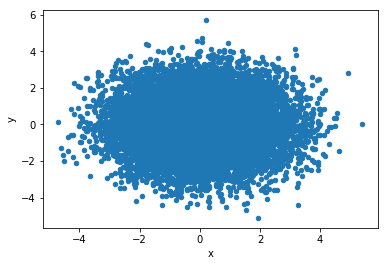

In [12]:
df[['x', 'y']].plot(kind='scatter', x='x', y='y')

## Trying to show this with Boken

I am using Jupyter Lab right now and the visualization functionality is just not working as desired. I'll probably have to test this in good ol' jupyter notebook

In [22]:
output_notebook()

Loading BokehJS ...

In [23]:
p = figure(x_range=(df['x'].min(), df['x'].max()), y_range=(df['y'].min(), df['y'].max()))

In [24]:
p.circle(df['x'], df['y'], line_color=None)

GlyphRenderer(id='a8b7fce0-86da-4af0-81d5-7277e0e56763', ...)

In [25]:
show(p)

# Back to getting this into Kafka

I have created two topics:

* sim_position
* sim_volocity

In [11]:
def get_offset(file_name):
    # many many strong assumptions... but valid for this exercise
    return int(file_name.split('_')[-1].split('.')[0])

In [12]:
def write_records(recs, producer, topic):
    for rec in recs:
        producer.send(topic, rec)

In [41]:
producer = KafkaProducer(value_serializer=lambda v: json.dumps(v).encode('utf-8'))

In [78]:
base_time = datetime(2017, 6, 1)
with ZipFile(PATH) as _zip:
    for fname in _zip.namelist():
        timer_start = datetime.now()
        df = pd.read_csv(_zip.open(fname), dtype={'id': str})
        timer_end = datetime.now()
        print '{} - csv load: {}'.format(fname, (timer_end - timer_start))
        timer_start = datetime.now()
        offset = get_offset(_zip.namelist()[0])
        timestamp = (base_time + timedelta(minutes=offset))
        timestamp = int((timestamp - datetime(1970, 1, 1)).total_seconds() * 1000)
        df['timestamp'] = timestamp
        df_pos = df[['x', 'y', 'z', 'id', 'timestamp']]
        df_vol = df[['vx', 'vy', 'vz', 'id', 'timestamp']]
        timer_end = datetime.now()
        print '{} - transformations {}'.format(fname, (timer_end - timer_start))
        timer_start = datetime.now()
        write_records(df_pos.to_dict(orient='records'), producer, 'sim-position')
        timer_end = datetime.now()
        print '{} - write to kafka {}\n ...............................'.format(fname, (timer_end - timer_start))

c_0000.csv - csv load: 0:00:00.204733
c_0000.csv - transformations 0:00:00.008968
c_0000.csv - write to kafka 0:00:16.572211
 ...............................
c_0100.csv - csv load: 0:00:00.191542
c_0100.csv - transformations 0:00:00.010896
c_0100.csv - write to kafka 0:00:13.564569
 ...............................
c_0200.csv - csv load: 0:00:00.142191
c_0200.csv - transformations 0:00:00.006669
c_0200.csv - write to kafka 0:00:12.517049
 ...............................
c_0300.csv - csv load: 0:00:00.185402
c_0300.csv - transformations 0:00:00.005866
c_0300.csv - write to kafka 0:00:12.338077
 ...............................
c_0400.csv - csv load: 0:00:00.180252
c_0400.csv - transformations 0:00:00.006270
c_0400.csv - write to kafka 0:00:17.476189
 ...............................
c_0500.csv - csv load: 0:00:00.199307
c_0500.csv - transformations 0:00:00.012154
c_0500.csv - write to kafka 0:00:14.291726
 ...............................
c_0600.csv - csv load: 0:00:00.234638
c_0600.csv - t

### Results from the command line:

```
bin/kafka-console-consumer.sh --bootstrap-server localhost:9092 --topic sim-position --from-beginning
...
{"y": -0.11054822, "x": 0.11621364, "z": 0.23641729, "id": "38146", "timestamp": 1496275200000}
{"y": 1.1567973, "x": 0.30246341, "z": -2.0369924999999998, "id": "38147", "timestamp": 1496275200000}
{"y": 0.011852292, "x": -0.03521074, "z": 0.79682457, "id": "38148", "timestamp": 1496275200000}
{"y": 0.37056017, "x": -0.039976314, "z": -0.34444728, "id": "38149", "timestamp": 1496275200000}
Processed a total of 102147 messages

```

## Experimenting with settings and variables

* linger_ms

In [81]:
producer = KafkaProducer(value_serializer=lambda v: json.dumps(v).encode('utf-8'), linger_ms=5)

In [82]:
base_time = datetime(2017, 6, 1)
with ZipFile(PATH) as _zip:
    for fname in _zip.namelist():
        timer_start = datetime.now()
        df = pd.read_csv(_zip.open(fname), dtype={'id': str})
        timer_end = datetime.now()
        print '{} - csv load: {}'.format(fname, (timer_end - timer_start))
        timer_start = datetime.now()
        offset = get_offset(_zip.namelist()[0])
        timestamp = (base_time + timedelta(minutes=offset))
        timestamp = int((timestamp - datetime(1970, 1, 1)).total_seconds() * 1000)
        df['timestamp'] = timestamp
        df_pos = df[['x', 'y', 'z', 'id', 'timestamp']]
        df_vol = df[['vx', 'vy', 'vz', 'id', 'timestamp']]
        timer_end = datetime.now()
        print '{} - transformations {}'.format(fname, (timer_end - timer_start))
        timer_start = datetime.now()
        write_records(df_pos.to_dict(orient='records'), producer, 'sim-position')
        timer_end = datetime.now()
        print '{} - write to kafka {}\n ...............................'.format(fname, (timer_end - timer_start))

c_0000.csv - csv load: 0:00:00.205535
c_0000.csv - transformations 0:00:00.006937
c_0000.csv - write to kafka 0:00:11.046353
 ...............................
c_0100.csv - csv load: 0:00:00.149831
c_0100.csv - transformations 0:00:00.006039
c_0100.csv - write to kafka 0:00:12.651185
 ...............................
c_0200.csv - csv load: 0:00:00.205739
c_0200.csv - transformations 0:00:00.007248
c_0200.csv - write to kafka 0:00:12.087515
 ...............................
c_0300.csv - csv load: 0:00:00.154809
c_0300.csv - transformations 0:00:00.006410
c_0300.csv - write to kafka 0:00:10.311056
 ...............................
c_0400.csv - csv load: 0:00:00.140150
c_0400.csv - transformations 0:00:00.005832
c_0400.csv - write to kafka 0:00:09.719945
 ...............................
c_0500.csv - csv load: 0:00:00.142367
c_0500.csv - transformations 0:00:00.008125
c_0500.csv - write to kafka 0:00:10.183748
 ...............................
c_0600.csv - csv load: 0:00:00.297910
c_0600.csv - t

## Observations and thoughts

It generally looks like increasing lingertime helped. My general thought on this is that json serialization is always going to be an expensive CPU process. Linger allows these records to be batched and then sent. It is important to remember that this is ultimantly a historical bulk data load as well. The overall rate was about 5.8k records per second (64k rows per csv file / ~ 11 seconds). 

With this being a stateless data load we should be able to paralize this. My next step is going to see if multithreading provides any overall benefits. Another strategy would be bundeling my json records together or potentially utalizing something like MessagePack to speed up serialization.

In [6]:
from multiprocessing import Pool

In [14]:
_zip = ZipFile(PATH)

def process_records(fname, zip_obj = _zip):
    producer = KafkaProducer(value_serializer=lambda v: json.dumps(v).encode('utf-8'), linger_ms=5)
    timer_start = datetime.now()
    df = pd.read_csv(_zip.open(fname), dtype={'id': str})
    timer_end = datetime.now()
    pprint('{} - csv load: {}'.format(fname, (timer_end - timer_start)))
    timer_start = datetime.now()
    offset = get_offset(_zip.namelist()[0])
    timestamp = (base_time + timedelta(minutes=offset))
    timestamp = int((timestamp - datetime(1970, 1, 1)).total_seconds() * 1000)
    df['timestamp'] = timestamp
    df_pos = df[['x', 'y', 'z', 'id', 'timestamp']]
    df_vol = df[['vx', 'vy', 'vz', 'id', 'timestamp']]
    timer_end = datetime.now()
    pprint('{} - transformations {}'.format(fname, (timer_end - timer_start)))
    timer_start = datetime.now()
    write_records(df_pos.to_dict(orient='records'), producer, 'sim-position')
    timer_end = datetime.now()
    pprint('{} - write to kafka {}\n ...............................'.format(fname, (timer_end - timer_start)))
    del producer
    del df_pos
    del df_vol
    del df


In [9]:
producer = KafkaProducer(value_serializer=lambda v: json.dumps(v).encode('utf-8'), linger_ms=5)

In [15]:
total_time_start = datetime.now()
pool = Pool(2)

base_time = datetime(2017, 6, 1)
# _zip = ZipFile(PATH)
names = _zip.namelist()
pool.map(process_records, names)
pool.close()
pool.join()
_zip.close()
total_time_end = datetime.now()

'c_0000.csv - csv load: 0:00:00.172696'
'c_0300.csv - csv load: 0:00:00.164289'
'c_0000.csv - transformations 0:00:00.008018'
'c_0300.csv - transformations 0:00:00.009849'
'c_0300.csv - write to kafka 0:00:11.533009\n ...............................'
'c_0000.csv - write to kafka 0:00:11.823410\n ...............................'
'c_0400.csv - csv load: 0:00:00.161305'
'c_0400.csv - transformations 0:00:00.008914'
'c_0100.csv - csv load: 0:00:00.165295'
'c_0100.csv - transformations 0:00:00.009474'
'c_0400.csv - write to kafka 0:00:10.531650\n ...............................'
'c_0500.csv - csv load: 0:00:00.298623'
'c_0500.csv - transformations 0:00:00.006535'
'c_0100.csv - write to kafka 0:00:10.831113\n ...............................'
'c_0200.csv - csv load: 0:00:00.207995'
'c_0200.csv - transformations 0:00:00.013360'
'c_0500.csv - write to kafka 0:00:13.282143\n ...............................'
'c_0600.csv - csv load: 0:00:00.228455'
'c_0600.csv - transformations 0:00:00.010226'
'c_

In [16]:
print total_time_end - total_time_start

0:01:52.919991


# Observations

Overall this appears to have the intended affect. This was not really tunning how messages are written to kafka, rather I just paralized the process. That being said, when reading information from a data source that produces timeseries data (what I am currently interested in) I typically find that the question around paralizing the writing of live data is typically driven by the capabilities of the data source.

In [102]:
consumer = KafkaConsumer(group_id='notebook_first_test',bootstrap_servers='localhost:9092', consumer_timeout_ms=1000,
                        value_deserializer=lambda v: json.loads(v))

In [103]:
partition = consumer.partitions_for_topic('sim-position')

In [61]:
# counter = 0
# consumer.subscribe(['sim-position'])
# for m in consumer:
#     print m
#     counter +=1
#     if counter > 5:
#         break

In [105]:
consumer.subscribe(['sim-position'])
consumer.poll(max_records=10)

{}

In [104]:
partition

{0}

In [106]:
consumer.partitions_for_topic('sim-position')

{0}

In [51]:
consumer.position(consumer.partitions_for_topic('sim-position'))

TypeError: partition must be a TopicPartition namedtuple

In [53]:
from kafka import SimpleClient
from kafka.protocol.offset import OffsetRequest, OffsetResetStrategy
from kafka.common import OffsetRequestPayload

topic = 'sim-position'

client = SimpleClient('localhost:9092')

partitions = client.topic_partitions[topic]
offset_requests = [OffsetRequestPayload(topic, p, -1, 1) for p in partitions.keys()]

offsets_responses = client.send_offset_request(offset_requests)

for r in offsets_responses:
    print "partition = %s, offset = %s"%(r.partition, r.offsets[0])

partition = 0, offset = 5213095


In [58]:
partitions

{0: 0}

In [59]:
offset_requests

[OffsetRequestPayload(topic='sim-position', partition=0, time=-1, max_offsets=1)]

In [63]:
consumer.seek_to_beginning()

In [100]:
consumer.subscribe(['sim-position'])
# print consumer.partitions_for_topic('sim-position')
# consumer.poll(max_records=10)

In [66]:
from kafka import TopicPartition

In [101]:
consumer.position(TopicPartition('sim-position',0))

AssertionError: Partition is not assigned

# Getting back on track

I will try to clean up the information above. That being said this exploration was needed to better understand the interfaces as the TL;DR version at https://github.com/dpkp/kafka-python did not seem to be enough in my case

In [75]:
import pandas as pd

In [107]:
consumer.subscribe(['sim-position'])
consumer.seek_to_beginning()

In [113]:
recs = consumer.poll(max_records=10)

In [115]:
pd.DataFrame.from_records([v.value for v in recs[recs.keys()[0]]])

,id,timestamp,x,y,z
0,1,1496275200000,0.485939,-0.524359,-0.531982
1,2,1496275200000,-0.065961,0.080844,-0.276031
2,3,1496275200000,-0.034809,0.076795,-0.390880
3,4,1496275200000,1.502104,1.442983,1.449747
4,5,1496275200000,-0.009554,0.538341,-0.267264
5,6,1496275200000,-0.356017,-0.045705,0.335006
6,7,1496275200000,-0.397190,-1.401627,-0.757772
7,8,1496275200000,-0.916657,0.643472,-0.146350
8,9,1496275200000,2.241766,0.790756,0.290989
9,10,1496275200000,-0.976209,0.445163,-0.705493


In [121]:
recs = consumer.poll(max_records=10)
pd.DataFrame.from_records([v.value for v in recs[recs.keys()[0]]])

,id,timestamp,x,y,z
0,21,1496275200000,-0.275568,-0.115546,-0.510623
1,22,1496275200000,1.820362,0.203837,0.467786
2,23,1496275200000,0.583323,-0.259002,0.073608
3,24,1496275200000,-0.719611,-1.029369,0.678575
4,25,1496275200000,-0.632132,-0.909770,1.735618
5,26,1496275200000,-0.191017,-0.281181,-0.089860
6,27,1496275200000,0.671022,-1.000295,0.430063
7,28,1496275200000,0.403255,0.188712,-0.430112
8,29,1496275200000,0.997805,1.627878,1.607263
9,30,1496275200000,-0.427248,-0.099082,-1.029367


In [112]:
consumer.position(TopicPartition('sim-position',0))

0